In [1]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [2]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/camcan_data",
    target_cols=["age"],
    index_col="Observations"
)

In [3]:
print(X.shape)
print(y.shape)
print(len(subjects))

(641, 3600)
(652,)
641


In [4]:
df_y = pd.read_csv("../data/raw/camcan_data/subjects.csv")
df_y.head()
df_y = df_y[["Observations", "age"]]
df_y = df_y.set_index("Observations", drop=True)
df_subs = pd.DataFrame(index=subjects)
df_subs = df_subs.merge(df_y, how="left", left_index=True, right_index=True)
y = df_subs["age"].astype(np.float64).values
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [5]:
print(X.shape)
print(y.shape)

(640, 3600)
(640,)


In [6]:
len(groups)

36

(array([26., 58., 72., 68., 76., 64., 71., 74., 86., 45.]),
 array([18., 25., 32., 39., 46., 53., 60., 67., 74., 81., 88.]),
 <BarContainer object of 10 artists>)

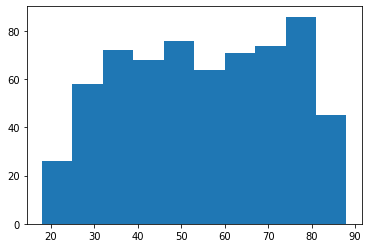

In [7]:
plt.hist(y)

In [8]:
np.median(y)

55.0

In [9]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10,
                   trim_nodes=0,
                   square_features=False):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
        
    if trim_nodes > 0:
        grp_mask = np.zeros_like(groups[0], dtype=bool)
        grp_mask[trim_nodes:-trim_nodes] = True
        X_mask = np.concatenate([grp_mask] * len(groups))

        groups_trim = []
        start_idx = 0
        
        for grp in groups:
            stop_idx = start_idx + len(grp) - 2 * trim_nodes
            groups_trim.append(np.arange(start_idx, stop_idx))
            start_idx += len(grp) - 2 * trim_nodes
            
        X_trim = X[:, X_mask]
    elif trim_nodes == 0:
        groups_trim = [grp for grp in groups]
        X_trim = np.copy(X)
    else:
        raise ValueError("trim_nodes must be non-negative.")
        
    if square_features:
        _n_samples, _n_features = X_trim.shape
        X_trim = np.hstack([X_trim, np.square(X_trim)])
        groups_trim = [np.concatenate([g, g + _n_features]) for g in groups_trim]
    
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.pipeline.make_base_afq_pipeline(
        imputer_kwargs={"strategy": "median"},
        power_transformer=power_transformer,
        scaler="standard",
        estimator=LassoCV,
        estimator_kwargs={
            "verbose": 0,
            "n_alphas": 50,
            "cv": 3,
            "n_jobs": 10,
            "max_iter": 500,
        },
        verbose=0,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )
    
    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].regressor_.coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].regressor_.alpha_
            else:
                cv_results[cv_idx]["coefs"] = pipe_skopt.named_steps["estimate"].coef_
                cv_results[cv_idx]["alpha"] = pipe_skopt.named_steps["estimate"].alpha_
        else:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].regressor_.estimators_
                ]
            else:
                cv_results[cv_idx]["coefs"] = [
                    est.coef_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
                cv_results[cv_idx]["alpha"] = [
                    est.alpha_ for est
                    in pipe_skopt.named_steps["estimate"].estimators_
                ]
        
        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [10]:
results = {}

In [11]:
trim_nodes = 0

results[f"bagging_target_transform_pure_lasso_trim{trim_nodes}"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=PCA,
    shuffle=False,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
    trim_nodes=trim_nodes, square_features=False,
)

results[f"bagging_pure_lasso_trim{trim_nodes}"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=PCA,
    shuffle=False,
    trim_nodes=trim_nodes, square_features=False,
)

CV index [  0], Elapsed time:  0:00:01.106642
CV index [  1], Elapsed time:  0:00:01.078033
CV index [  2], Elapsed time:  0:00:01.218096
CV index [  3], Elapsed time:  0:00:01.093290
CV index [  4], Elapsed time:  0:00:01.360955
CV index [  0], Elapsed time:  0:00:01.190571
CV index [  1], Elapsed time:  0:00:01.426561
CV index [  2], Elapsed time:  0:00:01.940823
CV index [  3], Elapsed time:  0:00:01.207025
CV index [  4], Elapsed time:  0:00:01.014964


In [12]:
for key, res in results.items():
    test_mae = [cvr["test_mae"] for cvr in res[0].values()]
    train_mae = [cvr["train_mae"] for cvr in res[0].values()]
    test_r2 = [cvr["test_r2"] for cvr in res[0].values()]
    train_r2 = [cvr["train_r2"] for cvr in res[0].values()]

    print(key, "mean MAE", np.mean(test_mae))
    print(key, "std MAE", np.std(test_mae))
    print(key, "mean R2", np.mean(test_r2))
    print(key, "std R2", np.std(test_r2))

bagging_target_transform_pure_lasso_trim0 mean MAE 6.653874056511265
bagging_target_transform_pure_lasso_trim0 std MAE 0.4597724354063769
bagging_target_transform_pure_lasso_trim0 mean R2 0.5112274921433742
bagging_target_transform_pure_lasso_trim0 std R2 0.3319836863791796
bagging_pure_lasso_trim0 mean MAE 5.842818896995505
bagging_pure_lasso_trim0 std MAE 0.3128799186367997
bagging_pure_lasso_trim0 mean R2 0.7381611345246745
bagging_pure_lasso_trim0 std R2 0.03116437626873482


In [13]:
with open("camcan_regression_pcr_lasso.pkl", "wb") as fp:
    pickle.dump(results, fp)